In [ ]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from utils import butter_bandpass_filter
from scipy.stats import skew
from ecg_dataset import ECGDataset
from feature_extractors import FeatureExtractorDataset

%reload_ext autoreload
%autoreload 2


## Training

In [21]:
dataset_path = Path('train')
data = ECGDataset(dataset_path, flatten_channels=True, window_duration=2)

Data records: 4, Target records: 4


In [ ]:
dataset = FeatureExtractorDataset(data.data, data.targets)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import torch

# Prepare the data for sklearn
features = torch.stack([f[0] for f in dataset])  # Extract features from the dataset
targets = np.array([f[1] for f in dataset]).flatten()  # Extract targets

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Convert PyTorch tensors to NumPy arrays for sklearn
X_train = X_train.numpy()
X_test = X_test.numpy()

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize features
    ('classifier', RandomForestClassifier(random_state=42))  # Default model
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9039


Text(95.72222222222221, 0.5, 'Actual')

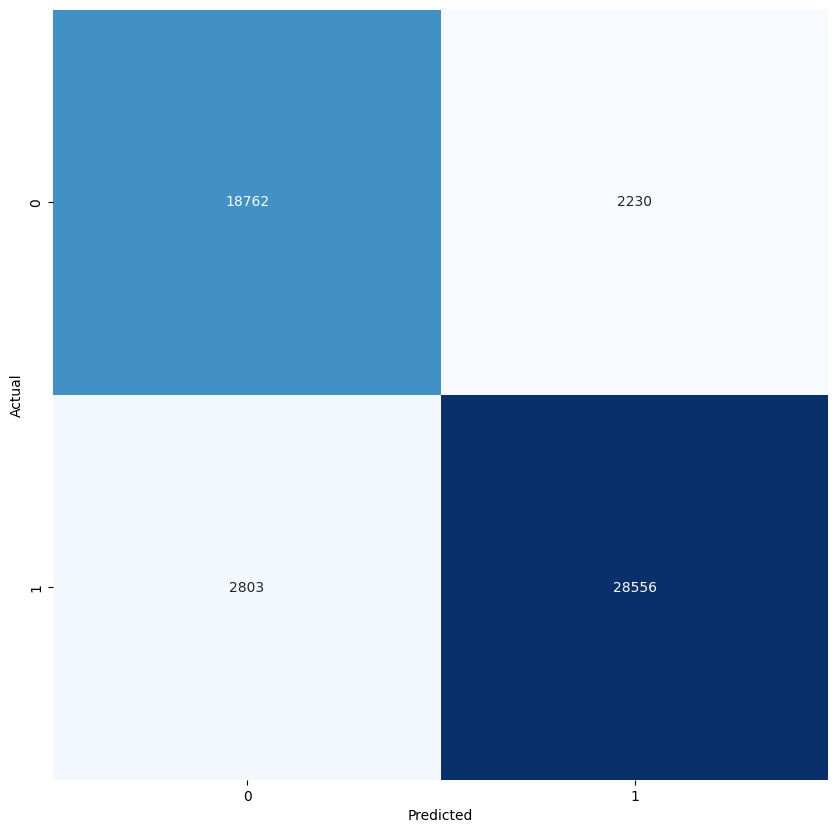

In [7]:
# confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Testing

In [16]:
ROOT_TEST_PATH = Path("test/")
test_data = {i:np.load(ROOT_TEST_PATH / f"data_{i}.npy") for i in [4,5]}
# We process each record independantly


def compute_predictions_on_record(path,model):
    TestDataset = ECGDataset(path, flatten_channels=True, window_duration=2)
    dataset = FeatureExtractorDataset(TestDataset.data, TestDataset.targets)
    features = torch.stack([f[0] for f in dataset])
    features = features.numpy()
    predictions = model.predict(features)
    return predictions


In [18]:
predictions = compute_predictions_on_record(ROOT_TEST_PATH, pipeline)

Dummy targets created for file data_4.npy, shape: (5, 13204)
Dummy targets created for file data_5.npy, shape: (5, 9319)
Data shape: (112615, 500), Targets shape: (112615, 1)


In [19]:

def format_array_to_target_format(array, record_number):
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5
    assert set(np.unique(array)) == {0, 1}
    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target
    

In [50]:
results = []
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data, model,["distances_2d", "esis", "amplitude", "mean_value", "std_dev", "amplitude_before", "amplitude_after", "wavelet"])
    formatted_preds = format_array_to_target_format(preds,record_number)
    results.extend(formatted_preds)
df = pd.DataFrame(results)
df.to_csv("submission.csv",index = False)

In [51]:
for record_number, data in test_data.items():
    print(record_number, len(data[0]))


4 6602015
5 4659937


In [ ]:
fourier_power.shape

(5, 13204)

In [ ]:
amplitude.shape

(5, 13204)

In [ ]:
13204*5

66020

In [ ]:
window_size = 100
num_windows = test_data[4].shape[-1] // window_size
# Initialiser un tableau pour stocker les distances
distances_2d = 0
# Calcul pour chaque sous-fenêtre
for i in range(num_windows):
    # Extraire les sous-fenêtres
    sub_window = test_data[4][..., i * window_size:(i + 1) * window_size]
    
    # Calcul des max, min, indices
    max_values = np.max(sub_window, axis=-1)
    min_values = np.min(sub_window, axis=-1)
    max_indices = np.argmax(sub_window, axis=-1)
    min_indices = np.argmin(sub_window, axis=-1)
    # Calcul des distances en 2D pour chaque sous-fenêtre
    distances_2d = distances_2d + np.sqrt((max_indices - min_indices)**2 + (max_values - min_values)**2)
# Initialiser un tableau pour stocker les distances

In [ ]:
distances_2d.shape

(5,)

In [ ]:
wavelet = []
for signal in test_data[4]:
    wavelet.append(calculate_wavelet_energy(signal))
wavelet = np.array(wavelet)

In [ ]:
len(wavelet)

5

In [ ]:
len(distances_2d)

5

In [ ]:
mean_value

array([ 134879.20459777, -331572.54254887,   45862.80569785, ...,
         -8482.00487871,    3281.53031914,    7115.11355835])

In [ ]:
df =compute_features_on_record(test_data[4])

In [ ]:
len(df["amplitude"])

5

In [ ]:
len(df["wavelet"])

5

In [ ]:
l = np.array([df[k] for k in ["distances_2d", "esis", "amplitude", "mean_value", "std_dev", "amplitude_before", "amplitude_after", "wavelet"]]) 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (8, 5) + inhomogeneous part.

In [ ]:
features = l.swapaxes(0,1).swapaxes(1,2)

In [ ]:
df["mean_value"]

array([[-112590.56259605],
       [   7078.69925347],
       [  37437.1169936 ],
       ...,
       [    634.16377671],
       [   1195.04638514],
       [    248.34712629]])

In [ ]:
min = np.min(reshaped_data,-1)  

In [ ]:
len(min)

68095

In [ ]:
min

array([-371712.47767991, -408636.27433739, -156274.0039681 , ...,
        -14067.76461123,   -2756.44995464,    5291.85501081])

In [ ]:
s=0
for i in test_data[4]:
    s = s +len(i)
print(s)

33010075


In [ ]:
s=0
for i in test_data[5]:
    s = s +len(i)
print(s)

23299685
